In [4]:
import warnings
warnings.filterwarnings('ignore')
from shapely import geometry
import geopandas as gpd
import pyproj          #cartographic projections and coordinate transformations library
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'shapely'

# 1. 坐标系 (对于地理数据非常重要！)

In [13]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# 利用name字段选择中国区域
china = world.loc[world['name'].isin(['China', 'Taiwan']), 'geometry']

In [14]:
# 1) 查看、设置坐标系
china.crs  #查看
china.to_crs('EPSG:2381')    # 换投影坐标系，用于有坐标系的情况
# china.set_crs('EPSG:2381') # 设置坐标系，用于无原始坐标系的情况

139    MULTIPOLYGON (((656071.071 2013492.275, 569189...
140    POLYGON ((1906585.754 2769729.696, 1861317.388...
Name: geometry, dtype: geometry

(array([ 70.,  80.,  90., 100., 110., 120., 130., 140.]),
 [Text(70.0, 0, '70'),
  Text(80.0, 0, '80'),
  Text(90.0, 0, '90'),
  Text(100.0, 0, '100'),
  Text(110.0, 0, '110'),
  Text(120.0, 0, '120'),
  Text(130.0, 0, '130'),
  Text(140.0, 0, '140')])

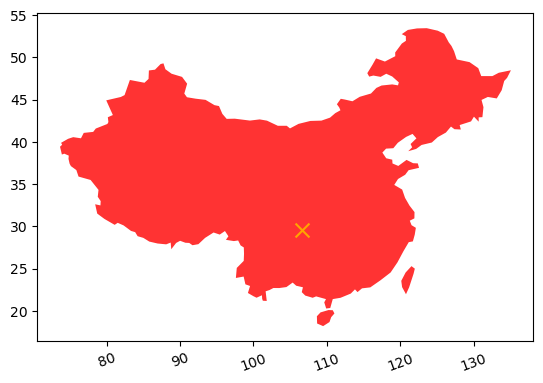

In [16]:
# 2) 统一坐标系
cq = gpd.GeoSeries([geometry.Point([106.561203, 29.558078])],
              crs='EPSG:4326')  # 生成geometry object的时候可以指定
fig, ax = plt.subplots()
# china.to_crs(crs='EPSG:2381').plot(ax=ax, color='red', alpha=0.8)  # case1: 不同坐标系
china.to_crs(crs=cq.crs).plot(ax=ax, color='red', alpha=0.8)    # case2: 相同坐标系
cq.plot(ax=ax, color='orange', markersize=100, marker='x')
plt.xticks(rotation=20)

# 2 数据结构

## 2.1 GeoSeries (*!GeoDataFrame 和 DataFrame区别)

### 2.1.1 GeoSeries中的基础几何对象

- **Points**

In [2]:
# 创建存放Point对象的GeoSeries
# 这里shapely.geometry.Point(x, y)用于创建单个点对象
gpd.GeoSeries([geometry.Point(0, 0),
               geometry.Point(0, 1),
               geometry.Point(1, 1),
               geometry.Point(1, 0)],
              index=['a', 'b', 'c', 'd'])

a    POINT (0.00000 0.00000)
b    POINT (0.00000 1.00000)
c    POINT (1.00000 1.00000)
d    POINT (1.00000 0.00000)
dtype: geometry

- **MultiPoint**

In [3]:
# 创建存放MultiPoint对象的GeoSeries
# 这里shapely.geometry.MultiPoint([(x1, y1), (x2, y2), ...])用于创建多点集合
gpd.GeoSeries([geometry.MultiPoint([(0, 1), (1, 0)]),
               geometry.MultiPoint([(0, 0), (1, 1)])],
              index=['a', 'b'])

a    MULTIPOINT (0.00000 1.00000, 1.00000 0.00000)
b    MULTIPOINT (0.00000 0.00000, 1.00000 1.00000)
dtype: geometry

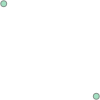

In [4]:
gpd.GeoSeries([geometry.MultiPoint([(0, 1), (1, 0)]),
               geometry.MultiPoint([(0, 0), (1, 1)])],
              index=['a', 'b'])[0]

- **LineString**

In [5]:
# 创建存放LineString对象的GeoSeries
# 这里shapely.geometry.LineString([(x1, y1), (x2, y2), ...])用于创建多点按顺序连接而成的线段
gpd.GeoSeries([geometry.LineString([(0, 0), (1, 1), (1, 0)]),
               geometry.LineString([(0, 0), (0, 1), (-1, 0)])],
              index=['a', 'b'])

a    LINESTRING (0.00000 0.00000, 1.00000 1.00000, ...
b    LINESTRING (0.00000 0.00000, 0.00000 1.00000, ...
dtype: geometry

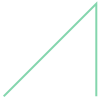

In [7]:
gpd.GeoSeries([geometry.LineString([(0, 0), (1, 1), (1, 0)]),
               geometry.LineString([(0, 0), (0, 1), (-1, 0)])],
              index=['a', 'b'])[1]

- **MultiLineString**

In [8]:
# 创建存放MultiLineString对象的GeoSeries
# 这里shapely.geometry.MultiLineString([LineString1, LineString2])
# 用于创建多条线段的集合
gpd.GeoSeries([geometry.MultiLineString([[(0, 0), (1, 1), (1, 0)],
                                        [(-0.1, 0), (0, 1), (-1, 0)]])],
              index=['a'])

a    MULTILINESTRING ((0.00000 0.00000, 1.00000 1.0...
dtype: geometry

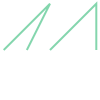

In [9]:
gpd.GeoSeries([geometry.MultiLineString([[(0, 0), (1, 1), (1, 0)],
                                        [(-0.5, 0), (0, 1), (-1, 0)]])],
              index=['a'])[0]

- **Polygon(无孔)**

In [10]:
# 创建存放无孔Polygon对象的GeoSeries
# 这里shapely.geometry.Polygon([(x1, y1), (x2, y2),...])用于创建无孔面
gpd.GeoSeries([geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])],
              index=['a'])

a    POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....
dtype: geometry

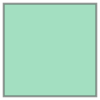

In [11]:
gpd.GeoSeries([geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0)])],
              index=['a'])[0]

- **Polygon(有孔)**

In [12]:
# 创建存放有孔Polygon对象的GeoSeries
# 这里shapely.geometry.Polygon(polygonExteriors, interiorCoords)用于创建有孔面
# 其中polygonExteriors用于定义整个有孔Polygon的外围，是一个无孔的多边形
# interiorCoords是用于定义内部每个孔洞（本质上是独立的多边形）的序列
gpd.GeoSeries([geometry.Polygon([(0,0),(10,0),(10,10),(0,10)], 
                                [((1,3),(5,3),(5,1),(1,1)), 
                                 ((9,9),(9,8),(8,8),(8,9))])])

0    POLYGON ((0.00000 0.00000, 10.00000 0.00000, 1...
dtype: geometry

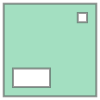

In [13]:
gpd.GeoSeries([geometry.Polygon([(0,0),(10,0),(10,10),(0,10)], 
                                [((1,3),(5,3),(5,1),(1,1)), 
                                 ((9,9),(9,8),(8,8),(8,9))])])[0]

- **MultiPolygon**

In [14]:
# 创建存放MultiPolygon对象的GeoSeries
# 这里shapely.geometry.MultiPolygon([Polygon1, Polygon2])用于创建多个面的集合
gpd.GeoSeries([geometry.MultiPolygon([geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0), (0, 0)]),
                                      geometry.Polygon([(2, 2), (2, 3), (3, 3), (3, 2), (2, 2)])])],
              index=['a'])

a    MULTIPOLYGON (((0.00000 0.00000, 0.00000 1.000...
dtype: geometry

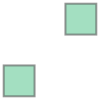

In [15]:
gpd.GeoSeries([geometry.MultiPolygon([geometry.Polygon([(0, 0), (0, 1), (1, 1), (1, 0), (0, 0)]),
                                      geometry.Polygon([(2, 2), (2, 3), (3, 3), (3, 2), (2, 2)])])],
              index=['a'])[0]

- **LinearRing**

In [16]:
# 创建存放LinearRing对象的GeoSeries
# 这里shapely.geometry.LinearRing([(x1, y1), (x2, y2),...])用于创建LinearRing
gpd.GeoSeries([geometry.LinearRing([(0, 0), (0, 1), (1, 1), (1, 0)])],
              index=['a'])

a    LINEARRING (0.00000 0.00000, 0.00000 1.00000, ...
dtype: geometry

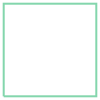

In [17]:
gpd.GeoSeries([geometry.LinearRing([(0, 0), (0, 1), (1, 1), (1, 0)])],
              index=['a'])[0]

### 2.1.2 GeoSeries常用属性

In [22]:
# 创建混合点线面的GeoSeries，这里第5个有孔多边形内部空洞创建时使用[::-1]颠倒顺序
# 是因为GeoSeries.plot()方法绘制有孔多边形的一个bug，即外部边框与内部孔洞创建时坐标
# 方向同为顺时针或顺时针时内部孔洞会自动被填充，如果你对这个bug感兴趣，可以前往
# https://github.com/geopandas/geopandas/issues/951查看细节
s = gpd.GeoSeries([geometry.Polygon([(0, 0), (0.5, 0.5), (1, 0), (0.5, -0.5)]),
                   geometry.Polygon([(1, 1), (1.5, 1.5), (2, 1), (1.5, -1.5)]),
                   geometry.Point(3, 3),
                   geometry.LineString([(2, 2), (0, 3)]),
                   geometry.Polygon([(4, 4), (8, 4), (8, 8), (4, 8)], 
                                [[(5, 5), (7, 5), (7, 7), (5, 7)][::-1]])])

# 在jupyter中开启matplotlib交互式绘图模式
# %matplotlib widget
# s.plot() # 对s进行简单的可视化

- **area**

In [19]:
# 计算s中各几何对象的面积
s.area

0     0.5
1     1.5
2     0.0
3     0.0
4    12.0
dtype: float64

- **bounds**

In [36]:
# 计算s中各几何对象内部孔洞边界列表
s.interiors

0                                        []
1                                        []
2                                      None
3                                      None
4    [LINEARRING (5 7, 7 7, 7 5, 5 5, 5 7)]
dtype: object

- **length**

In [37]:
# 计算s中各几何对象边长
s.length

0     2.828427
1     6.513233
2     0.000000
3     2.236068
4    24.000000
dtype: float64

In [38]:
# 计算s中各几何对象box左下角与右上角的坐标
s.bounds

,minx,miny,maxx,maxy
0,0.0,-0.5,1.0,0.5
1,1.0,-1.5,2.0,1.5
2,3.0,3.0,3.0,3.0
3,0.0,2.0,2.0,3.0
4,4.0,4.0,8.0,8.0


- **geom_type**

In [25]:
# 计算s中各几何对象类型
s.geom_type

0       Polygon
1       Polygon
2         Point
3    LineString
4       Polygon
dtype: object

- **exterior**与**interiors**

In [26]:
# 计算s中各几何对象外边界
s.exterior

0    LINEARRING (0.00000 0.00000, 0.50000 0.50000, ...
1    LINEARRING (1.00000 1.00000, 1.50000 1.50000, ...
2                                                 None
3                                                 None
4    LINEARRING (4.00000 4.00000, 8.00000 4.00000, ...
dtype: geometry

- **is_valid**

In [27]:
s_ = gpd.GeoSeries([geometry.Polygon([(4, 0), (6, 1), (4, 1), (6, 0)]),
               geometry.MultiPolygon([geometry.Polygon([(4, 0), (5, 0.5), (6, 0)]), 
                                      geometry.Polygon([(5, 0.5), (6, 1), (4, 1)])])])

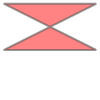

In [28]:
s_[0]

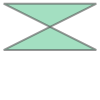

In [29]:
s_[1]

In [30]:
s_[0].intersection(s_[1])

TopologyException: Input geom 0 is invalid: Self-intersection at 5 0.5


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x000001FD2A9B7550>

In [31]:
s_.is_valid

0    False
1     True
dtype: bool

- **boundary**

<AxesSubplot:>

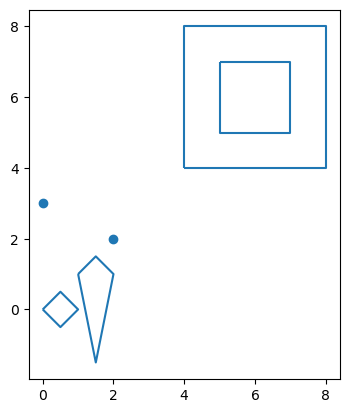

In [32]:
# 返回各几何对象的低维简化表示
s.boundary.plot()

- **centroid**

<AxesSubplot:>

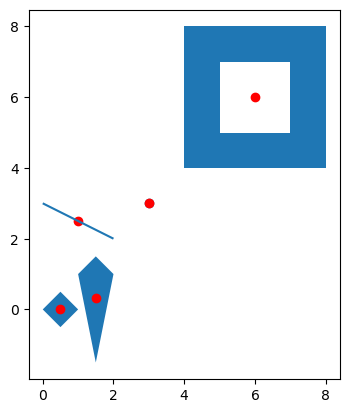

In [33]:
# 返回各几何对象的重心
ax = s.plot() # 绘制s
s.centroid.plot(ax=ax, color='red') # 叠加绘制重心结果

- **convex_hull**

<AxesSubplot:>

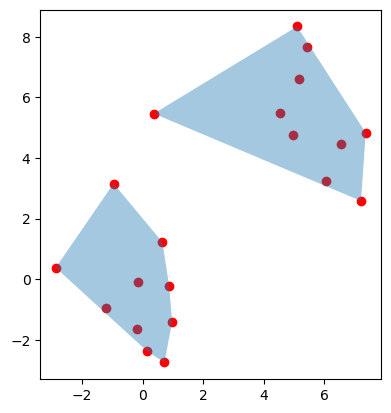

In [34]:
import numpy as np

# 创建两团独立的MultiPoint
s__ = gpd.GeoSeries([geometry.MultiPoint(np.random.normal(loc=0, scale=2, size=[10, 2]).tolist()),
               geometry.MultiPoint(np.random.normal(loc=5, scale=2, size=[10, 2]).tolist())])

ax = s__.plot(color='red') # 绘制s__
s__.convex_hull.plot(ax=ax, alpha=0.4) # 叠加绘制各自对应凸包

- **envelope**

<AxesSubplot:>

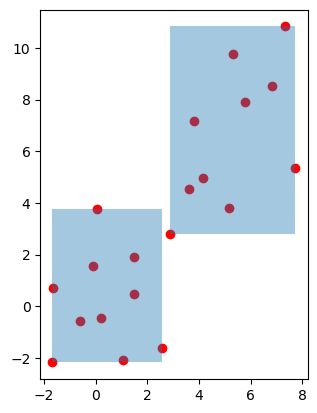

In [35]:
import numpy as np

# 创建两团独立的MultiPoint
s__ = gpd.GeoSeries([geometry.MultiPoint(np.random.normal(loc=0, scale=2, size=[10, 2]).tolist()),
               geometry.MultiPoint(np.random.normal(loc=5, scale=2, size=[10, 2]).tolist())])

ax = s__.plot(color='red') # 绘制s__
s__.envelope.plot(ax=ax, alpha=0.4) # 叠加绘制各自对应envelope，调低填充透明度以显示更明显

- **mapping 从shapely对象中提取元素**

In [40]:
from shapely.geometry import mapping 

In [53]:
mapping(s[3])['coordinates'][0]

(2.0, 2.0)

## 2.2 GeoDataFrame

### 2.2.1 GeoDataFrame基础

In [33]:
contents = [(loc, 0.5) for loc in range(0, 10, 2)]
geo_df = gpd.GeoDataFrame(data=contents, 
                          geometry=[geometry.MultiPoint(np.random.normal(loc=loc, scale=scale, size=[10, 2]).tolist()) 
                                    for loc, scale in contents],
                          columns=['均值', '标准差'])
geo_df

,均值,标准差,geometry
0,0,0.5,"MULTIPOINT (0.18193 0.30002, 0.75158 0.38686, ..."
1,2,0.5,"MULTIPOINT (1.43067 1.40640, 1.65145 1.01231, ..."
2,4,0.5,"MULTIPOINT (4.20904 3.75744, 4.05318 4.61695, ..."
3,6,0.5,"MULTIPOINT (6.01883 6.35274, 6.17306 5.76938, ..."
4,8,0.5,"MULTIPOINT (7.21866 7.38495, 8.29127 8.40514, ..."


- **添加矢量列但未定义**

In [34]:
geo_df = gpd.GeoDataFrame(contents, columns=['均值', '标准差'])
geo_df['raw_points'] = [geometry.MultiPoint(np.random.normal(loc=loc, scale=scale, size=[10, 2]).tolist()) 
                                    for loc, scale in contents]
# 尝试查看矢量类型
geo_df.geom_type

AttributeError: No geometry data set yet (expected in column 'geometry'.

- **重新为`GeoDataFrame`指定矢量列**

In [35]:
geo_df.set_geometry('raw_points').geom_type

0    MultiPoint
1    MultiPoint
2    MultiPoint
3    MultiPoint
4    MultiPoint
dtype: object

- **多个矢量列切换**

In [36]:
geo_df = gpd.GeoDataFrame(contents, columns=['均值', '标准差'])
geo_df['raw_points'] = [geometry.MultiPoint(np.random.normal(loc=loc, scale=scale, size=[10, 2]).tolist()) 
                                    for loc, scale in contents]
geo_df.set_geometry('raw_points', inplace=True) # inplace=True表示对原数据进行更新

# 绘制第一图层
ax = geo_df.plot(color='red')
geo_df['convex_hull'] = geo_df.convex_hull
# 切换矢量主列
geo_df.set_geometry('convex_hull', inplace=True)

# 绘制第二图层
geo_df.plot(ax=ax, color='blue', alpha=0.4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 2.2.2 GeoDataFrame数据索引

<AxesSubplot:>

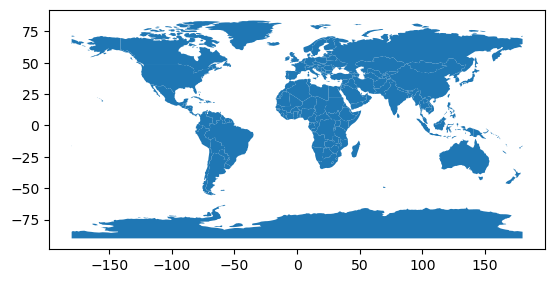

In [54]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot()

In [56]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [57]:
# 选择人口在10亿以上的pop_est、name列
world.loc[world['pop_est'] >= 1000000000, ['pop_est', 'name']]

,pop_est,name
98,1.366418e+09,India
139,1.397715e+09,China


In [58]:
# 选择前10行，前4列的数据
world.iloc[:10, :4]

,pop_est,continent,name,iso_a3
0,889953.0,Oceania,Fiji,FJI
1,58005463.0,Africa,Tanzania,TZA
2,603253.0,Africa,W. Sahara,ESH
3,37589262.0,North America,Canada,CAN
4,328239523.0,North America,United States of America,USA
5,18513930.0,Asia,Kazakhstan,KAZ
6,33580650.0,Asia,Uzbekistan,UZB
7,8776109.0,Oceania,Papua New Guinea,PNG
8,270625568.0,Asia,Indonesia,IDN
9,44938712.0,South America,Argentina,ARG


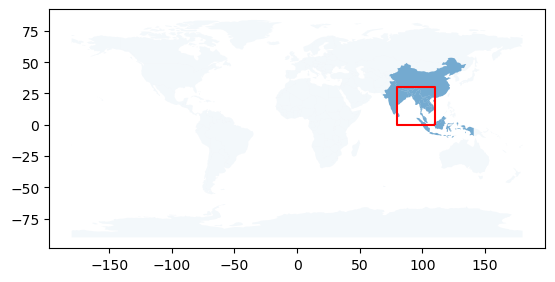

In [62]:
# 选择与东经80度-110度，北纬0度-30度范围相交的几何对象
part_world = world.cx[80:110, 0:30]

# 绘制第一图层：世界地图
ax = world.plot(alpha=0.05)
# 绘制第二图层：.cx所选择的地区
ax = part_world.plot(ax=ax, alpha=0.6)
# 绘制第三图层：.cx条件示意图
ax = gpd.GeoSeries([geometry.box(minx=80, miny=0, maxx=110, maxy=30).boundary])\
    .plot(ax=ax, color='red')

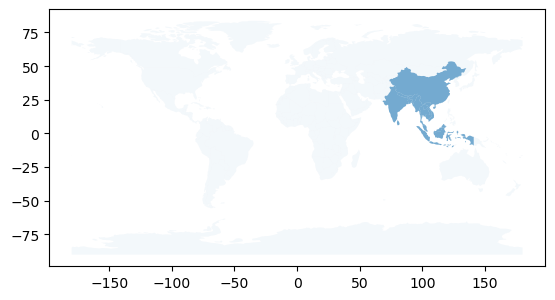

In [65]:
# 绘制第一图层：世界地图
ax = world.plot(alpha=0.05)
ax = part_world.plot(ax=ax, alpha=0.6)
# 绘制第三图层：.cx条件示意图